# Lung Cancer Classification using CNN(Convolutional Nueral network)

Objective: Build a Convolution nueral network to classify the image into lung_n(normal), lung_scc(cancer) and lung_aca(cancer).

Dataset: COntains 15000 images of lung tissue belongs to the three classes.

In [ ]:
# Important things to note
#1. Its a CNN problem- so atleast one layer must be convolutional layer
#2. process the images in batches to avoid crashing
#3. We are using augmented dataset

## 1. Data extraction

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import statement
import zipfile

# extract zip files
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/lung_image_sets.zip','r')
zip_ref.extractall('/content') # extratc files to root folder
zip_ref.close()

## 2. Read the Data

In [ ]:
import tensorflow as tf #tensorflow is an open-source library that is used for Machine Learning
from tensorflow import keras#keras is an open-source library that is used for Machine Learning
from keras import Sequential # import Sequential model from keras
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Dropout,MaxPooling2D # different layers from keras

In [ ]:
# in CNN, we assume that all images that we are passing have same size. so we are setting image_size parameterimage size-256x256
# setting the batch size, will help to run the code without crashing
# label mode is categorical. so classes are represented one hot encoded
# its a multiclass classification problem
# split the dataset into train & validation set, 20% data will be used for validation

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/lung_image_sets",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(256, 256), # size of the image
    batch_size=32, # input will be processed as a batch of 32
    shuffle = True, # shuffle the data
    labels='inferred',
    label_mode='categorical',
)


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


In [ ]:
train_ds.class_names

['lung_aca', 'lung_n', 'lung_scc']

# 3. Normalise the input

In [ ]:
# Create a normalization layer
normalization_layer = keras.layers.Rescaling(1./255)

# Apply normalization to the datasets
# Normalisation doen't change the shape or color channels of the image
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# 4. Display the images of 3 classes

In [ ]:
import cv2 # to handle image files
import matplotlib.pyplot as plt # For visualisation
import numpy as np # For arithmetic operation
from PIL import Image # For image processing
import os

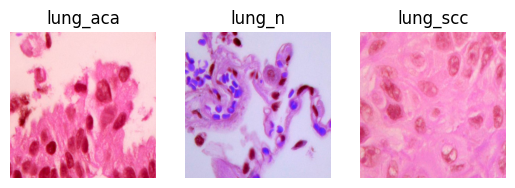

In [ ]:
path = '/content/lung_image_sets' # path to dataset
classes=['lung_aca','lung_n', 'lung_scc'] # target classes

for i,cat in enumerate(classes):
  plt.subplot(1,3,i+1) # subplot indices start from 1
  images = os.listdir(f'{path}/{cat}') # listing the items inside the directory, image names as list
  test_image=cv2.imread(f'{path}/{cat}/{images[2]}') # reading the image file
  plt.imshow(test_image) # displaying the image
  plt.title(cat) # set the title
  plt.axis('off') # set the axis off
plt.show()

# 5. Build the Initial Model

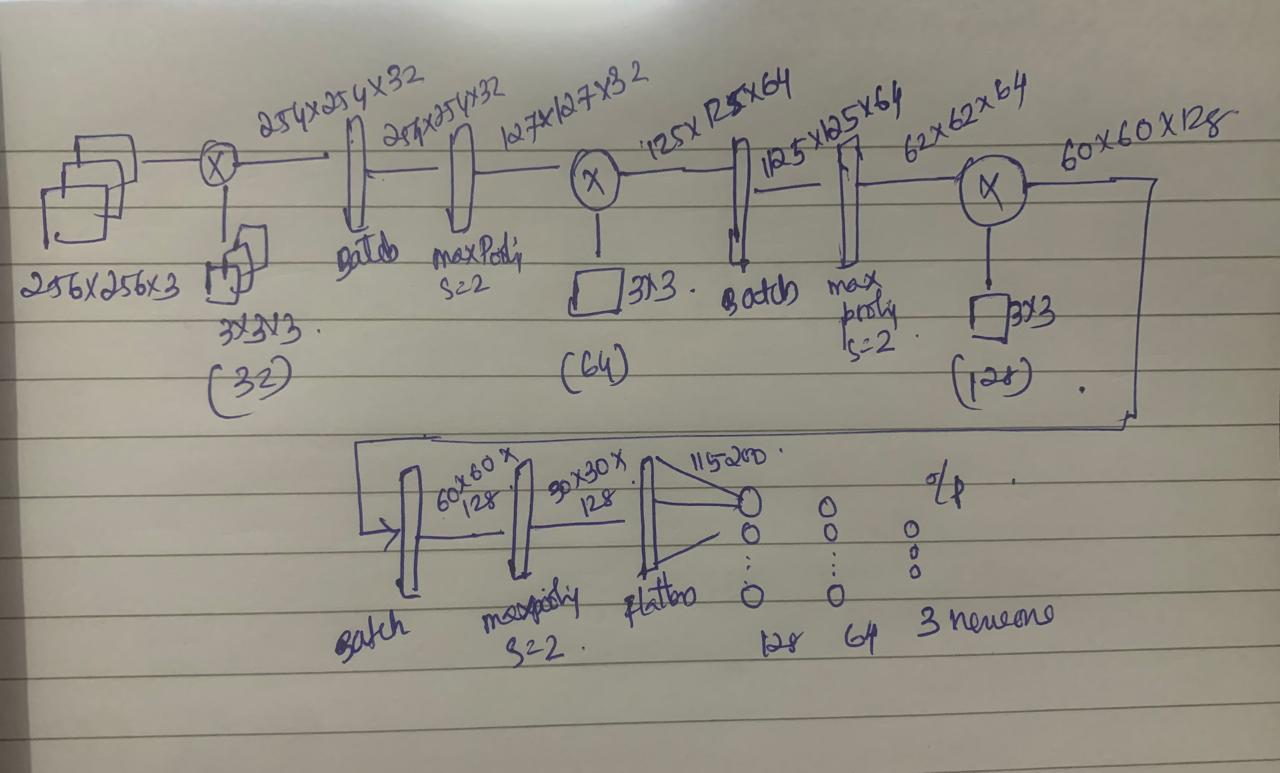

In [ ]:
# convoltion BAse
# we are uisng keras sequential model
# in CNN, we will have Convolution layers- where we are applying filters to extract the primitive features(like edges)

model=Sequential()
# we are applying 32 filters of shape 3x3, No padding and activation function is ReLU
# our input is RGB image that why input shape set to 256,256,3
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(256,256,3)))
# Batch normalization helps prevent overfitting and speeds up training of deep neural networks
# it add a new layer that performs standardizing and normalizing operations on the input of the layer
model.add(BatchNormalization())
# we are adding pooling layer to reduce the spatial dimension
# stride is the step of the convolution along x & y axis of the volume
# when we increase stride value to 2,2 .it will reduce the size of the output volume
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

#add one more convolution layer with 64 filter
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

#add one more convolution layer with 128 filter
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2))


# convert 2D into ID using Flatten method
model.add(Flatten())

# Fully Flattened layer-ANN
# added dropouts to fasten the training, to prevent overfitting. 20% neouron will dropout from the training process
# add a Dense layer with 128 neurons
model.add(Dense(128,activation='relu'))


# add another Dense layer with 64 neurons
model.add(Dense(64,activation='relu'))


# since its a multi class classification problem, we need to use softmax activation function
# we have 3 classes, so we need 3 neurons at output layer
model.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,323 (56.64 MB)

 Trainable params: 14,847,875 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

Model summary explanation:
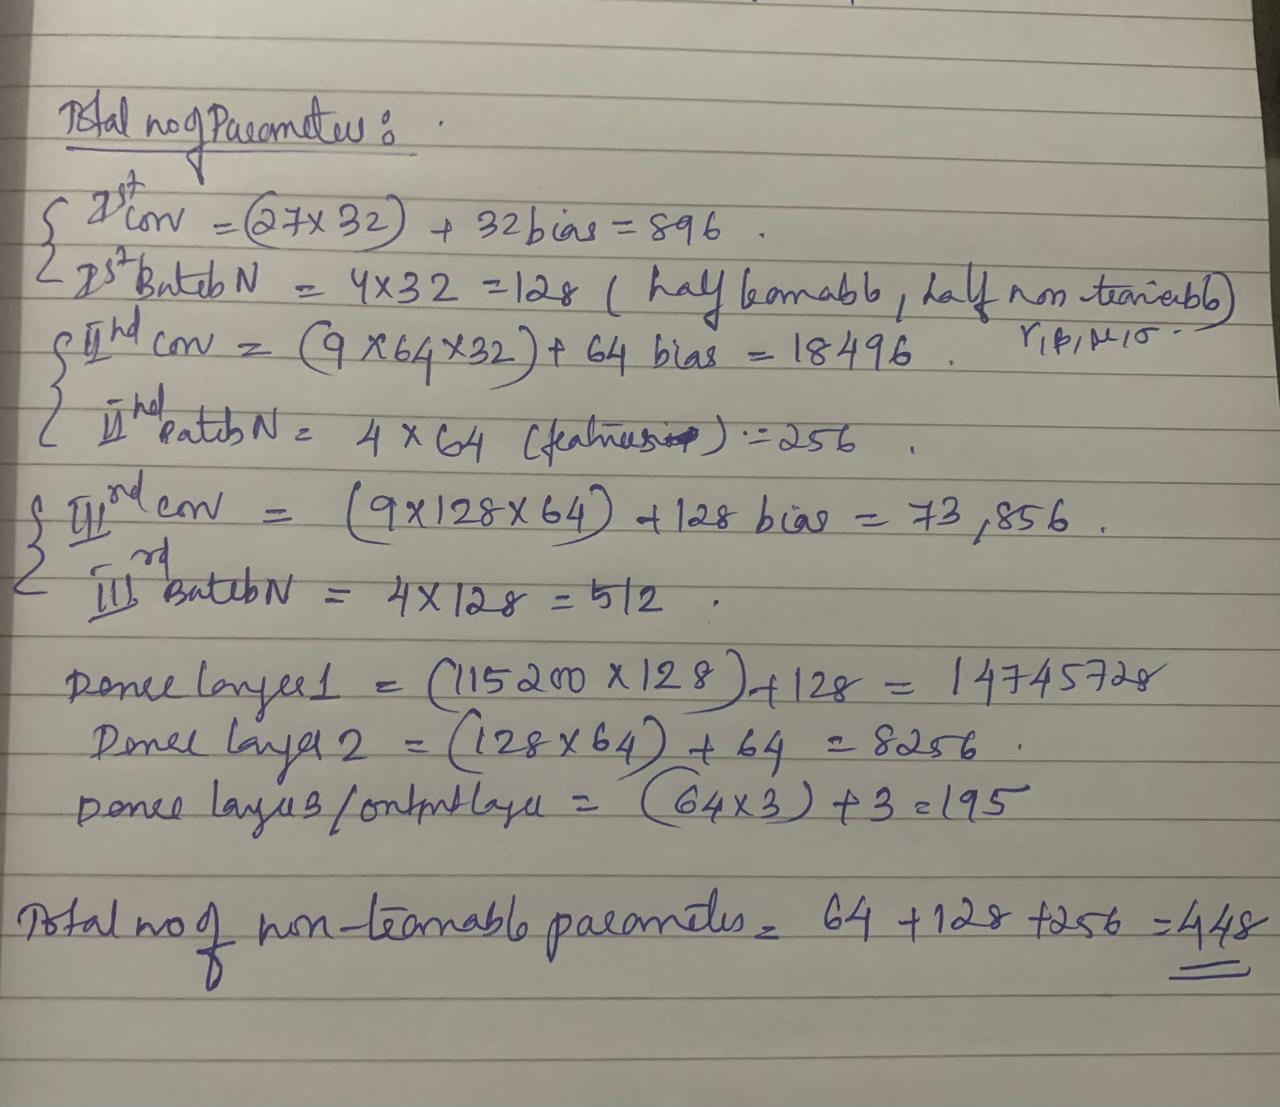

#### Compile & Train the model with evaluation Metrics as accuracy

In [ ]:
# compile the model, with metrics as accuracy
# loss function is categorical_crossentropy, since its a multi class classification problem
# optimiser is Adam, it will apply on loss function to find the trainable parameter with min loss

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# model with Accuracy
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history=model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
375/375 [==============================] - 60s 137ms/step - loss: 1.1444 - accuracy: 0.8767 - val_loss: 7.3441 - val_accuracy: 0.8330
Epoch 2/10
375/375 [==============================] - 54s 141ms/step - loss: 0.3110 - accuracy: 0.9268 - val_loss: 1.1083 - val_accuracy: 0.8297
Epoch 3/10
375/375 [==============================] - 53s 138ms/step - loss: 0.1925 - accuracy: 0.9488 - val_loss: 3.9589 - val_accuracy: 0.8287
Epoch 4/10
375/375 [==============================] - 50s 132ms/step - loss: 0.1460 - accuracy: 0.9579 - val_loss: 0.2505 - val_accuracy: 0.9327
Epoch 5/10
375/375 [==============================] - 53s 141ms/step - loss: 0.2263 - accuracy: 0.9499 - val_loss: 0.5401 - val_accuracy: 0.8863
Epoch 6/10
375/375 [==============================] - 53s 139ms/step - loss: 0.2193 - accuracy: 0.9553 - val_loss: 1.7948 - val_accuracy: 0.8160
Epoch 7/10
375/375 [==============================] - 53s 138ms/step - loss: 0.0727 - accuracy: 0.9779 - val_loss: 0.2017 - val_ac

Note:
1. train & validation accuracy is almost same. there is decrease in loss also.
2. The model is learning and improving over epochs, as evidenced by the decreasing loss and increasing accuracy.
3. Loss values are low value, and its graduallty decreasing. but there is a fluctuation
4. There is a signs of overfitting

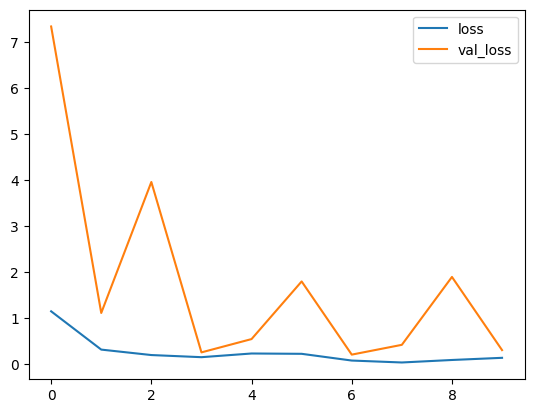

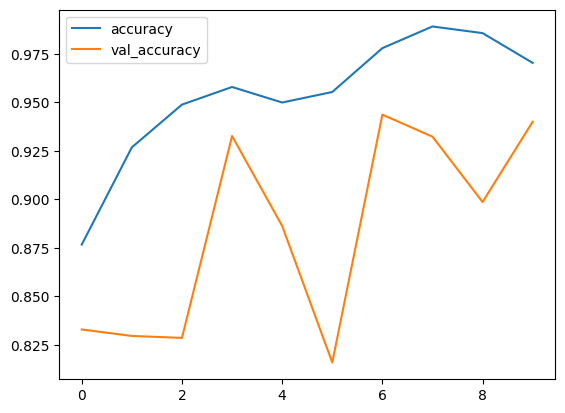

In [ ]:
#plot the loss & accuracy graphs
import pandas as pd
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


Note:
1. The training loss decreases over epochs but  validation loss starts to increase after the initial decrease.
2. training accuracy is more than validation accuracy
3. Both the above points indicates model is overfitting.

#### Compile & Train the model with evaluation Metrics as F1 score

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['f1_score'])

In [ ]:
# model with F1-score
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history=model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 143ms/step - f1_score: 0.9548 - loss: 0.1318 - val_f1_score: 0.9194 - val_loss: 0.2252
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - f1_score: 0.9718 - loss: 0.0813 - val_f1_score: 0.9401 - val_loss: 0.2435
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - f1_score: 0.9724 - loss: 0.1049 - val_f1_score: 0.9524 - val_loss: 0.2024
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - f1_score: 0.9718 - loss: 0.0959 - val_f1_score: 0.9356 - val_loss: 0.2489
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 147ms/step - f1_score: 0.9855 - loss: 0.0555 - val_f1_score: 0.9385 - val_loss: 0.3236
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - f1_score: 0.9871 - loss: 0.0393 - val_f1_score: 0.9648 - val_loss: 0.1243
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - f1_score: 0.9913 - loss: 0.0283 - val_f1_score: 0.9539 - val_loss: 0.2897
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 130ms/step - f1_score: 0.9751 - loss: 0

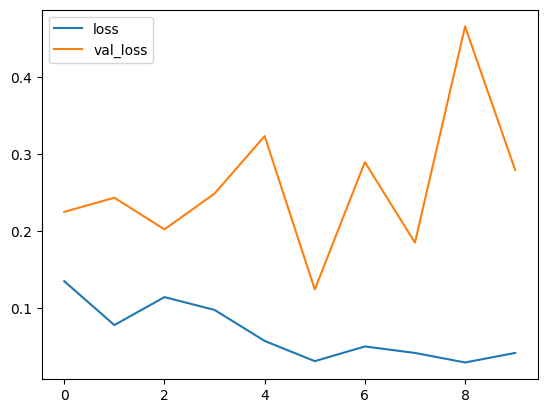

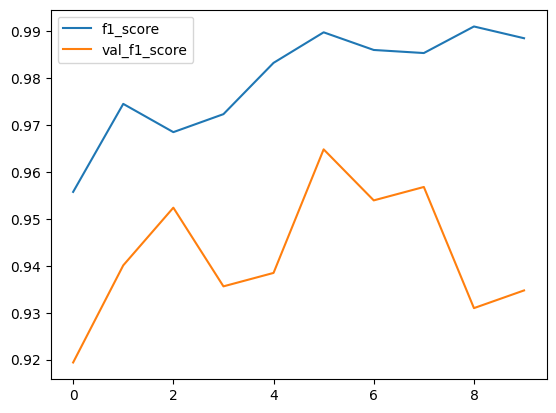

In [ ]:
#plot the loss & accuracy graphs
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

history_df['f1_score']=history_df['f1_score'].apply(lambda x: np.mean(x))
history_df['val_f1_score']=history_df['val_f1_score'].apply(lambda x: np.mean(x))

history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['f1_score','val_f1_score']].plot()
plt.show()

Notes:
1. The training loss continues to decrease and the F1 score increases, indicating the model is learning well on the training data.
2. The validation F1 score does not show consistent improvement.
3. Model is overfitting.

#### Testing the model

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('/content/drive/MyDrive/my_initial_model.keras')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/my_initial_model.keras')
test_image_1=cv2.imread('/content/drive/MyDrive/Test_lung/adano.jpeg')
test_image_1=cv2.resize(test_image_1,(256,256))
test_image_1=test_image_1.reshape((1,256,256,3))
predictions=model.predict(test_image_1)
class_labels = train_ds.class_names

predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
lung_aca


# 6. Added early stopping and Dropout layers to handle Overfitting

In [ ]:
# convoltion BAse
# we are uisng keras sequential model
# in CNN, we will have Convolution layers- where we are applying filters to extract the primitive features(like edges)

model1=Sequential()
# we are applying 32 filters of shape 3x3, No padding and activation function is ReLU
# our input is RGB image that why input shape set to 256,256,3
model1.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
# Batch normalization helps prevent overfitting and speeds up training of deep neural networks
# it add a new layer that performs standardizing and normalizing operations on the input of the layer
model1.add(BatchNormalization())
# we are adding pooling layer to reduce the spatial dimension
# stride is the step of the convolution along x & y axis of the volume
# when we increase stride value to 2,2 .it will reduce the size of the output volume
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#add one more convolution layer with 64 filter
model1.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#add one more convolution layer with 128 filter
model1.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


# convert 2D into ID using Flatten method
model1.add(Flatten())

# Fully Flattened layer-ANN
# added dropouts to fasten the training, to prevent overfitting. 20% neouron will dropout from the training process
# add a Dense layer with 128 neurons
model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.2))

# add another Dense layer with 64 neurons
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.2))

# since its a multi class classification problem, we need to use softmax activation function
# we have 3 classes, so we need 3 neurons at output layer
model1.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compile the model with Accuracy as an evaluation metrics

In [ ]:
from tensorflow.keras.optimizers import Adam
model1.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2,
                   monitor='val_accuracy',
                   restore_best_weights=True)

In [ ]:
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history_1=model1.fit(train_ds,epochs=15,validation_data=val_ds,callbacks = [es])

Epoch 1/15
375/375 [==============================] - 60s 144ms/step - loss: 0.9933 - accuracy: 0.8300 - val_loss: 0.3252 - val_accuracy: 0.8957
Epoch 2/15
375/375 [==============================] - 54s 141ms/step - loss: 0.3517 - accuracy: 0.8836 - val_loss: 0.1976 - val_accuracy: 0.9270
Epoch 3/15
375/375 [==============================] - 50s 133ms/step - loss: 0.2865 - accuracy: 0.9018 - val_loss: 0.5260 - val_accuracy: 0.7593
Epoch 4/15
375/375 [==============================] - 54s 142ms/step - loss: 0.2792 - accuracy: 0.9079 - val_loss: 0.3132 - val_accuracy: 0.8927


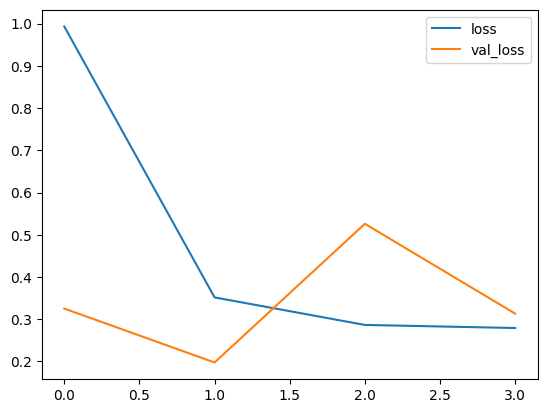

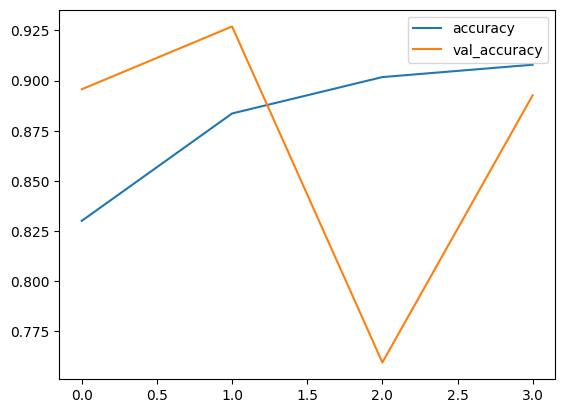

In [ ]:
#plot the loss & accuracy graphs
import pandas as pd
import matplotlib.pyplot as plt
history1_df = pd.DataFrame(history_1.history)
history1_df.loc[:,['loss','val_loss']].plot()
history1_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Note:
1. Training process is stopped when the model starts overfitting
2. Validation accuracy improved
3. Validation accuracy is more than trainig  accuracy

#### Compile the model with evaluation metrics as F1_Score

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score

# using F1Score from tensorflow
model1.compile(optimizer=Adam(),
               loss='categorical_crossentropy',
               metrics=[F1Score(average='macro')])

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2,
                   monitor='val_f1_score',
                   mode='max',
                   restore_best_weights=True)

In [ ]:
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history_1=model1.fit(train_ds,epochs=15,validation_data=val_ds,callbacks = [es])

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - f1_score: 0.8059 - loss: 3.2088 - val_f1_score: 0.4472 - val_loss: 9.3182
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 138ms/step - f1_score: 0.8257 - loss: 0.6299 - val_f1_score: 0.8697 - val_loss: 0.3642
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 130ms/step - f1_score: 0.8571 - loss: 0.4524 - val_f1_score: 0.8927 - val_loss: 0.3190
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - f1_score: 0.8815 - loss: 0.3504 - val_f1_score: 0.5811 - val_loss: 1.2788
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - f1_score: 0.8781 - loss: 0.3912 - val_f1_score: 0.8827 - val_loss: 0.2998


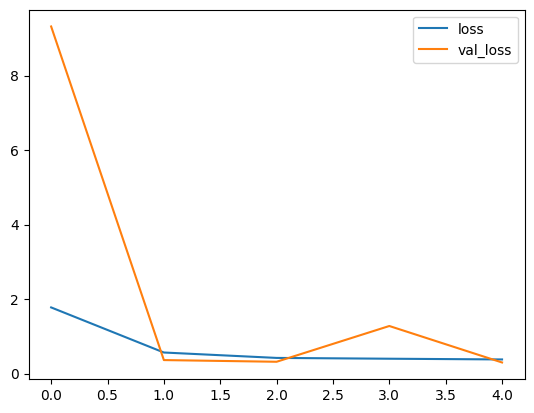

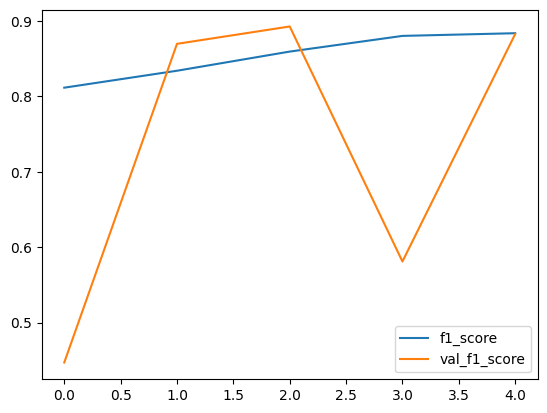

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

history_1_df = pd.DataFrame(history_1.history)

history_1_df['f1_score']=history_1_df['f1_score'].apply(lambda x: np.mean(x))
history_1_df['val_f1_score']=history_1_df['val_f1_score'].apply(lambda x: np.mean(x))

history_1_df.loc[:,['loss','val_loss']].plot()
history_1_df.loc[:,['f1_score','val_f1_score']].plot()
plt.show()

Note:
1. Validation F1 score is  slightly higher than traing F1_score
2. training & validation loss are dropped down almost same value

In [ ]:
# Save the entire model as a `.keras` zip archive.
model1.save('/content/drive/MyDrive/Early_stopping_with_Dropout.keras')

In [ ]:
import cv2

#### Test the model

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Early_stopping_with_Dropout.keras')
test_image_1=cv2.imread('/content/drive/MyDrive/Test_lung/adano.jpeg')
test_image_1=cv2.resize(test_image_1,(256,256))
test_image_1=test_image_1.reshape((1,256,256,3))
predictions=new_model.predict(test_image_1)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
[[0. 1. 0.]]


In [ ]:
class_labels = ['lung_aca', 'lung_n', 'lung_scc']

predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

lung_n


# 6. Change the loss function to sparse_cross_entropy to handle overfitting

In [ ]:
# load the dataset with class label as int
train_ds1, val_ds1 = keras.utils.image_dataset_from_directory(
    "/content/lung_image_sets",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    labels='inferred',
    label_mode='int',
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


In [ ]:
# Create a normalization layer
normalization_layer = keras.layers.Rescaling(1./255)

# Apply normalization to the datasets
# Normalisation doen't change the shape or color channels of the image
train_ds_norm = train_ds1.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = val_ds1.map(lambda x, y: (normalization_layer(x), y))

range: 0.0 - 1.0
Image shape: (256, 256, 3)


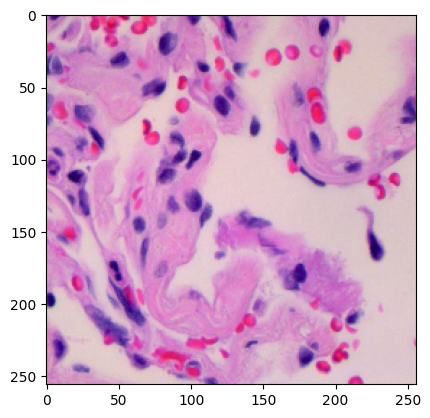

In [ ]:
# view one image from train_ds_norm

for images, labels in train_ds_norm.take(1):
    image = images[0].numpy()
    print("range:", image.min(), "-", image.max())
    plt.imshow(image)# mapping the normalised image to the full color range for displa
    print("Image shape:", image.shape)

In [ ]:
# convoltion BAse
# we are uisng keras sequential model
# in CNN, we will have Convolution layers- where we are applying filters to extract the primitive features(like edges)

model2=Sequential()
# we are applying 32 filters of shape 3x3, No padding and activation function is ReLU
# our input is RGB image that why input shape set to 256,256,3
model2.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
# Batch normalization helps prevent overfitting and speeds up training of deep neural networks
# it add a new layer that performs standardizing and normalizing operations on the input of the layer
model2.add(BatchNormalization())
# we are adding pooling layer to reduce the spatial dimension
# stride is the step of the convolution along x & y axis of the volume
# when we increase stride value to 2,2 .it will reduce the size of the output volume
model2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#add one more convolution layer with 64 filter
model2.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#add one more convolution layer with 128 filter
model2.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


# convert 2D into ID using Flatten method
model2.add(Flatten())

# Fully Flattened layer-ANN
# added dropouts to fasten the training, to prevent overfitting. 20% neouron will dropout from the training process
# add a Dense layer with 128 neurons
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.2))

# add another Dense layer with 64 neurons
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.2))

# since its a multi class classification problem, we need to use softmax activation function
# we have 3 classes, so we need 3 neurons at output layer
model2.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compile the model with evaluation metrics as Accuracy

In [ ]:
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2,
                   monitor='val_accuracy',
                   restore_best_weights=True)

In [ ]:
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history_2=model2.fit(train_ds_norm,epochs=15,validation_data=val_ds_norm,callbacks = [es])

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 152ms/step - accuracy: 0.7922 - loss: 4.8304 - val_accuracy: 0.3870 - val_loss: 11.2416
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 135ms/step - accuracy: 0.8599 - loss: 0.5256 - val_accuracy: 0.7320 - val_loss: 17.1362
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.8812 - loss: 0.4684 - val_accuracy: 0.9433 - val_loss: 0.1662
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 131ms/step - accuracy: 0.8905 - loss: 0.3553 - val_accuracy: 0.9330 - val_loss: 0.1712
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.9122 - loss: 0.2449 - val_accuracy: 0.9447 - val_loss: 0.1601
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.9350 - loss: 0.1817 - val_accuracy: 0.9363 - val_loss: 0.1671
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 135ms/step - accuracy: 0.9369 - loss: 0.1836 - val_accuracy: 0.9503 - val_loss: 0.1273
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - accuracy: 0.9581 - loss:

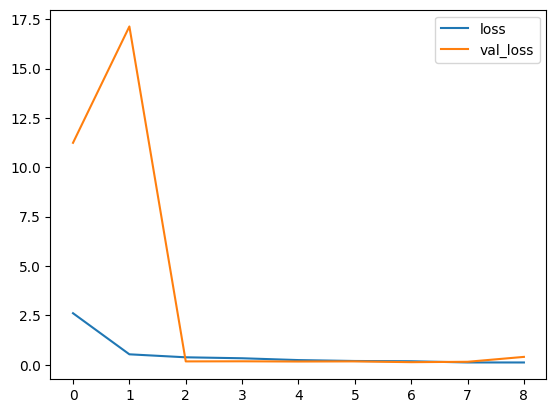

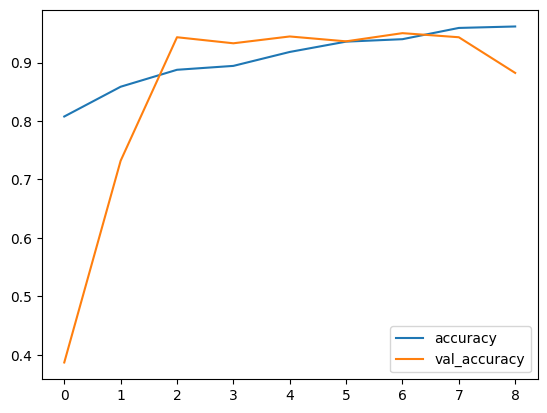

In [ ]:
#plot the loss & accuracy graphs
import pandas as pd
import matplotlib.pyplot as plt
history2_df = pd.DataFrame(history_2.history)
history2_df.loc[:,['loss','val_loss']].plot()
history2_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Note:

1. validation accuracy is slightly more than Training accuracy.
2. No overfitting

In [ ]:
model2.save('/content/drive/MyDrive/sparse_loss_func.keras')

#### Testing the model

In [ ]:
new_model=tf.keras.models.load_model('/content/drive/MyDrive/sparse_loss_func.keras')
test_image_2=cv2.imread('/content/drive/MyDrive/Test_lung/lung_bn.jpeg')
test_image_2=cv2.resize(test_image_2,(256,256))
test_image_2=test_image_2.reshape((1,256,256,3))
predictions=new_model.predict(test_image_2)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
lung_n


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/sparse_loss_func.keras')
test_image_2 = cv2.imread('/content/drive/MyDrive/Test_lung/lung_bn.jpeg')
test_image_2 = cv2.resize(test_image_2, (256, 256))

class_labels = ['lung_aca', 'lung_n', 'lung_scc']

# normalize the image
#test_image_2 = test_image_2.astype('float32') / 255.0

# Reshape the image
test_image_2 = test_image_2.reshape((1, 256, 256, 3))

predictions = new_model.predict(test_image_2)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]

print(predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
lung_n


In [ ]:
import tensorflow as tf
import cv2
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

new_model = tf.keras.models.load_model('/content/drive/MyDrive/My_models_ICT_project/Copy of sparse_loss_func.keras')
test_image_2 = cv2.imread('/content/drive/MyDrive/Test_lung/scc.jpeg')
test_image_2 = cv2.resize(test_image_2, (256, 256))

class_labels = ['lung_aca', 'lung_n', 'lung_scc']

# normalize the image
test_image_2 = test_image_2.astype('float32') / 255.0

# Reshape the image
test_image_2 = test_image_2.reshape((1, 256, 256, 3))

predictions = new_model.predict(test_image_2)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]

print(predicted_class_label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
lung_n


In [ ]:
import tensorflow as tf
import cv2
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

new_model = tf.keras.models.load_model('/content/drive/MyDrive/My_models_ICT_project/Copy of sparse_loss_func.keras')
test_image_2 = cv2.imread('/content/drive/MyDrive/Test_lung/adano.jpeg')
test_image_2 = cv2.resize(test_image_2, (256, 256))

class_labels = ['lung_aca', 'lung_n', 'lung_scc']

# normalize the image
test_image_2 = test_image_2.astype('float32') / 255.0

# Reshape the image
test_image_2 = test_image_2.reshape((1, 256, 256, 3))

predictions = new_model.predict(test_image_2)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]

print(predicted_class_label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
lung_scc


#### Compile the model with evaluation metrics as F1_Score

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score

# using F1Score from tensorflow
model2.compile(optimizer=Adam(),
               loss='sparse_categorical_crossentropy',
               metrics=[F1Score(average='macro')])

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2,
                   monitor='val_f1_score',
                   mode='max',
                   restore_best_weights=True)

In [ ]:
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history_2=model2.fit(train_ds_norm,epochs=15,validation_data=val_ds_norm,callbacks = [es])

In [ ]:
#plot the loss & accuracy graphs
import pandas as pd
import matplotlib.pyplot as plt
history2_df = pd.DataFrame(history_2.history)
history2_df.loc[:,['loss','val_loss']].plot()
history2_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Note: For F1Score to work correctly with multiclass classification, we need one-hot encoded labels. Because of that model fitting code is throwing error. Error is about the model expect 3 output feature but got one.

#7. Fine tuning using Keras Tuner

In [ ]:
import tensorflow as tf #tensorflow is an open-source library that is used for Machine Learning
from tensorflow import keras#keras is an open-source library that is used for Machine Learning
from keras import Sequential # import Sequential model from keras
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Dropout,MaxPooling2D # different layers from keras

In [ ]:
# import statement
import zipfile

# extract zip files
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/lung_image_sets.zip','r')
zip_ref.extractall('/content') # extratc files to root folder
zip_ref.close()

In [ ]:
# load the dataset with class label as int
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/lung_image_sets",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    labels='inferred',
    label_mode='categorical',
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


In [ ]:
# Create a normalization layer
normalization_layer = keras.layers.Rescaling(1./255)

# Apply normalization to the datasets
# Normalisation doen't change the shape or color channels of the image
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
!pip install -U keras-tuner #install keras tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_conv_layers', 1, 5)): # tuning the no of convolution layers
        if i == 0:
          # tuning no of filters, kernal size and activation function
            model.add(Conv2D(hp.Int('num_filters'+str(i), 32, 128, step=16),
                             kernel_size=hp.Choice('conv_kernel_size'+str(i), values=[3, 5]),
                             activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid']),
                             input_shape=(256, 256, 3)))
        else:
            model.add(Conv2D(hp.Int('num_filters'+str(i), 32, 128, step=16),
                             kernel_size=hp.Choice('conv_kernel_size'+str(i), values=[3, 5]),
                             activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid'])))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())

    # tuning the no of hidden layers,drop out % in FC layers
    for i in range(hp.Int('num_hidden_layers', 1, 5)):
        model.add(Dense(hp.Int('units'+str(i), 32, 128, step=16),
                        activation=hp.Choice('activation_ann'+str(i), values=['relu', 'tanh', 'sigmoid'])))
        model.add(Dropout(hp.Float('dropout'+str(i), 0, 0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    # tuning the learning rate
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 3)
# search best parameter
tuner.search(train_ds,epochs=3,validation_data=val_ds)

Trial 2 Complete [00h 03m 37s]
val_accuracy: 0.515333354473114

Best val_accuracy So Far: 0.878333330154419
Total elapsed time: 00h 06m 46s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
5                 |4                 |num_conv_layers
96                |80                |num_filters0
3                 |3                 |conv_kernel_size0
sigmoid           |relu              |activation0
2                 |3                 |num_hidden_layers
80                |48                |units0
relu              |sigmoid           |activation_ann0
0.2               |0.1               |dropout0
0.001             |0.01              |learning_rate
112               |32                |num_filters1
3                 |3                 |conv_kernel_size1
sigmoid           |relu              |activation1
32                |32                |num_filters2
3                 |3                 |conv_kernel_size2
relu              |relu              |activation2
1

In [ ]:
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 80)        │           2,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 80)        │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 80)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │          23,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │         301,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 348,339 (1.33 MB)

 Trainable params: 347,987 (1.33 MB)

 Non-trainable params: 352 (1.38 KB)

In [ ]:
# fit the model
from keras.callbacks import EarlyStopping


history_4=model.fit(train_ds,
          epochs=10,
          validation_data=val_ds,
          initial_epoch=4)

Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - accuracy: 0.8817 - loss: 0.3360 - val_accuracy: 0.8083 - val_loss: 0.4017
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - accuracy: 0.8808 - loss: 0.3164 - val_accuracy: 0.5913 - val_loss: 1.7637
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.8612 - loss: 0.3396 - val_accuracy: 0.5350 - val_loss: 2.0238
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 138ms/step - accuracy: 0.8941 - loss: 0.2817 - val_accuracy: 0.8163 - val_loss: 0.4143
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.8858 - loss: 0.2958 - val_accuracy: 0.4257 - val_loss: 4.1105
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 132ms/step - accuracy: 0.8862 - loss: 0.3054 - val_accuracy: 0.7563 - val_loss: 0.5080


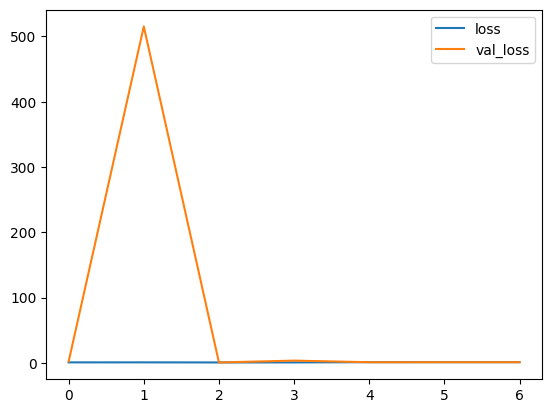

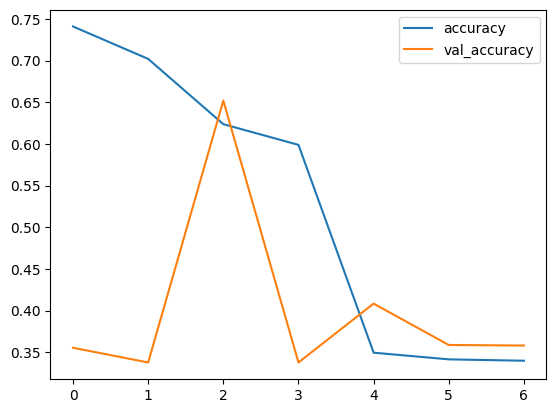

In [ ]:
#plot the loss & accuracy graphs
import pandas as pd
import matplotlib.pyplot as plt
history_4_df = pd.DataFrame(history_4.history)
history_4_df.loc[:,['loss','val_loss']].plot()
history_4_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

Note:
1. We got low training & validation accuracy.
2. to get a better tuned model, we shoud increase the number of trials & no of epochs.
3. In our case we use low epochs & number of trials.
4. thats the reason why the model is not good.

In [ ]:
# save the model to google drive

model.save('/content/drive/MyDrive/kears_tuner_v2.keras')

In [ ]:
import tensorflow as tf
print(tf.__version__)
# Keras 2.2.4

2.17.0


#### Test the model

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/kears_tuner_v2.keras')
test_image_2 = cv2.imread('/content/drive/MyDrive/Test_lung/lung_bn.jpeg')
test_image_2 = cv2.resize(test_image_2, (256, 256))

class_labels = ['lung_aca', 'lung_n', 'lung_scc']

# normalize the image
test_image_2 = test_image_2.astype('float32') / 255.0

# Reshape the image
test_image_2 = test_image_2.reshape((1, 256, 256, 3))

predictions = new_model.predict(test_image_2)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]

print(predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
lung_aca


# 8. Comparison of model Performance

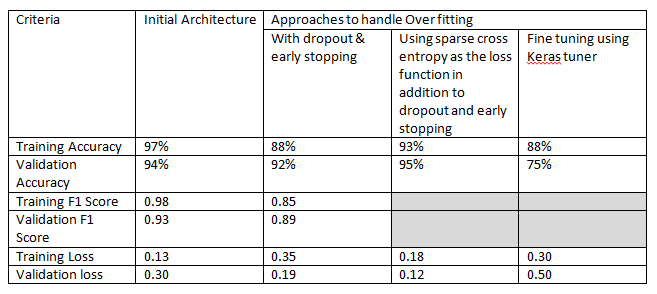

Notes:
1.  Initial architecture had slightly higher training metrics
2.  The sparse cross entropy model shows better balance between performance and generalization
3. The fine-tuning approach using Keras tuner was  underperformed, tuning process need to refined with more trials & moer epochs

## 9. Remarks

The model using sparse cross entropy loss function with dropout and early stopping appears to be the best performing model, balancing performance and generalization.